In [1]:
using Interact
using LCMGL
using StaticArrays
using CoordinateTransformations
using RigidBodyDynamics

In [2]:
import DrakeVisualizer: Visualizer, draw

In [3]:
include("../src/arms.jl")
include("../src/depth_sensors.jl")

DepthSensors

In [4]:
# Construct the manipulator
arm = Arms.two_link_arm(true);

# Construct the sensor and draw its view rays for debugging
sensor = DepthSensors.Kinect(41, 41);
camera_origin = SVector(1., 0, 4)
camera_tform = compose(Translation(camera_origin), LinearMap(AngleAxis(pi, 1, 0, 0)))
DepthSensors.draw_rays(sensor, camera_tform)

state = Arms.ManipulatorState(arm)

body = collect(bodies(arm.mechanism))[2]

RigidBody: "body1"

In [5]:
Arms.draw(state)

DrakeVisualizer.Visualizer(DrakeVisualizer.Robot(DrakeVisualizer.Link[DrakeVisualizer.Link(DrakeVisualizer.GeometryData[DrakeVisualizer.GeometryData{CoordinateTransformations.IdentityTransformation,GeometryTypes.HomogenousMesh{FixedSizeArrays.Point{3,Float64},GeometryTypes.Face{3,Int64,0},Void,Void,Void,Void,Void}}(HomogenousMesh(
    vertices: 876xFixedSizeArrays.Point{3,Float64},     faces: 1748xGeometryTypes.Face{3,Int64,0}, )
,CoordinateTransformations.IdentityTransformation(),RGBA{Float64}(1.0,0.0,0.0,0.5))],"skin_1")]),1,PyLCM.LCM(PyObject <LCM object at 0x7fb95a9792d0>))

In [6]:
# A helper function that takes the two arm angles, computes the implicit 
# surface, performs a raycast, and draws the result. 
state = Arms.ManipulatorState(arm)
function raycast_arm(x1, x2)
    set_configuration!(state.mechanism_state, [x1, x2])
    Arms.draw(state)
    surfaces = Arms.skin(state)
    warn("only using the first surface")
    points = DepthSensors.raycast_points(surfaces[1], sensor, camera_tform)
    LCMGLClient("raycast") do lcmgl
        LCMGL.color(lcmgl, 0, 1, 0)
        point_size(lcmgl, 5)
        begin_mode(lcmgl, LCMGL.POINTS)
        for point in points
            vertex(lcmgl, convert(Vector, point)...)
        end
        end_mode(lcmgl)
        switch_buffer(lcmgl)
    end
    points
end

raycast_arm (generic function with 1 method)

In [7]:
@manipulate for x1 = linspace(-pi, pi, 101), x2 = linspace(-pi, pi, 101)
    points = raycast_arm(x1, x2)
end;

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x1",0.0,linspace(-3.141592653589793,3.141592653589793,101),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x2",0.0,linspace(-3.141592653589793,3.141592653589793,101),".3f",true)

In [8]:
# Difference between two angles, compensating for wraparound
# (taken from angleDiff.m in Drake)
function angle_diff(phi1, phi2)
    mod(phi2 - phi1 + pi, 2*pi) - pi;
end

angle_diff (generic function with 1 method)

In [9]:
using DataFrames, DataArrays
using ForwardDiff

In [38]:
# Now let's try to use the raycast data to recover the joint angles.
# We'll do that by choosing a true (hidden) robot state:
x_true = [-1; 1.3]

# Now we can raycast that true state to get a set of sensed points:
sensed_points = raycast_arm(x_true...)

# Our cost function takes the two joint angles and returns the 
# squared sum of the value of the implicit surface at those sensed
# points. If we've recovered the true joint state, then that sum
# should be nearly zero. 
warn("only using the first surface")
cost = x -> begin
    state = Arms.ManipulatorState(arm, eltype(x), Float64)
    set_configuration!(state.mechanism_state, x)
    Arms.draw(state, false)
    skin = Arms.skin(state)[1]
    return sum(point -> skin(point)^2, sensed_points)
end


# Use autodiff to prepare a function that will evaluate the gradient
# of that cost:
function cost_and_gradient(x)
    out = GradientResult(x)
    ForwardDiff.gradient!(out, cost, x)
    ForwardDiff.value(out), ForwardDiff.gradient(out)
end
    
# g_cost = x -> ForwardDiff.gradient(cost, x)

trials = []

function test_gradient_descent()
    for i = 1:100
        errors = []
        xs = []
        costs = []

        # We'll initialize our estimate with a uniformly random pair
        # of joint angles
        x_estimated = rand(2) * 2*pi - pi

        # Now we use gradient descent to recover the joint angles
        for i = 1:50
            push!(xs, x_estimated)
            push!(errors, norm(angle_diff(x_estimated, x_true)))

            # Evaluate the gradient of the point values w.r.t. the
            # joint angles:
            ci, gi = cost_and_gradient(x_estimated)
            push!(costs, ci)

            if any(isnan, gi)
                @show x_estimated
                error("NaN in gradient")
            end

            # Descend the gradient
            step = -ci ./ gi
            step = sign(step) .* min.(0.05, abs.(gi))
            x_estimated += step
#             x_estimated -= 0.0005 * gi
        end
        push!(trials, DataFrame(x=xs, err=errors, cost=costs))
#         push!(trials, (xs, errors))
    end
end

test_gradient_descent (generic function with 1 method)

In [39]:
test_gradient_descent()
# trials = []
# Profile.clear
# @time @profile test_gradient_descent()
# ProfileView.view()

In [40]:
using Gadfly

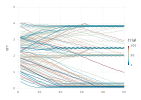

In [41]:
# Now we can plot the progress of each trial

Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial"))

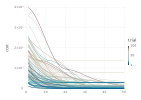

In [42]:
Gadfly.plot([layer(trial, y="cost", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial"))

In [43]:
state = Arms.ManipulatorState(arm)
@manipulate for j = 1:length(trials), i = 1:size(trials[1], 1)
    trial = trials[j]
    set_configuration!(state.mechanism_state, SVector{2, Float64}(trial[:x][i]))
    Arms.draw(state)
    trial[:x][i], trial[:cost][i]
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,"d",true)

Interact.Slider{Int64}(Signal{Int64}(25, nactions=0),"i",25,1:50,"d",true)

([0.196067,2.95054],108.35618882234797)

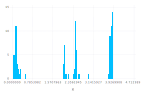

In [16]:
# A histogram of the final cost of each trial shows that most random
# configurations eventually converged to the correct answer (a final
# cost near 0.0), but that some got stuck in local minima

Gadfly.plot(x=[trial[:err][end] for trial in trials], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [44]:
# Now let's repeat the trial, but starting within + or - 0.5 of the true
# joint angles (to simulate running online with a good initial guess).

x_true = [-1; 1.3]

sensed_points = raycast_arm(x_true...)

warn("only using first surface")
cost = x -> begin
    state = Arms.ManipulatorState(arm, eltype(x), Float64)
    Arms.set_configuration!(state.mechanism_state, x)
    Arms.draw(state, false)
    skin = Arms.skin(state)[1]
    return sum(point -> skin(point)^2, sensed_points)
end

function cost_and_gradient(x)
    out = GradientResult(x)
    ForwardDiff.gradient!(out, cost, x)
    ForwardDiff.value(out), ForwardDiff.gradient(out)
end

trials_close = []

for i = 1:100
    errors = []
    xs = []
    costs = []

    # Start within +- 0.5 of x_true
    x_estimated = (rand(2) - 0.5) + x_true

    # Now we use gradient descent to recover the joint angles
    for i = 1:50
        push!(xs, x_estimated)
        push!(errors, norm(angle_diff(x_estimated, x_true)))

        # Evaluate the gradient of the point values w.r.t. the
        # joint angles:
        ci, gi = cost_and_gradient(x_estimated)
        push!(costs, ci)

        if any(isnan, gi)
            @show x_estimated
            error("NaN in gradient")
        end

        # Descend the gradient
        step = -ci ./ gi
        step = (0.95)^i * sign(step) .* min.(0.05, abs.(gi))
        x_estimated += step
    end
    push!(trials_close, DataFrame(x=xs, err=errors, cost=costs))
end

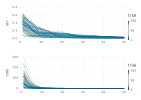

In [45]:
vstack(Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials_close)]..., 
    Guide.colorkey("trial")),
    Gadfly.plot([layer(trial, y="cost", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials_close)]..., 
    Guide.colorkey("trial")))

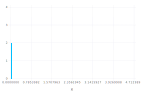

In [46]:
# When starting out reasonably close to the correct configuration, every
# single sample converged to the true joint angles. The histogram confirms:

Gadfly.plot(x=[trial[:err][end] for trial in trials_close], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [48]:
@manipulate for j = 1:length(trials_close), i = 1:size(trials_close[1], 1)
    trial = trials_close[j]
    Arms.set_configuration!(state, SVector{2, Float64}(trial[:x][i]))
    Arms.draw(state)
    trial[:x][i], trial[:cost][i]
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,"d",true)

Interact.Slider{Int64}(Signal{Int64}(25, nactions=0),"i",25,1:50,"d",true)

([-0.977444,1.22659],0.2568176509515807)